In [1]:
import constants
import feats
import transactions
import utils

import pickle
import numpy as np
import pandas as pd

from scipy.stats import entropy

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
from imp import  reload

In [3]:
reload(transactions)

<module 'transactions' from '/home/cyh/Instacart/transactions.py'>

In [4]:
tle = transactions.TransLogExtractor(constants.RAW_DATA_DIR, constants.FEAT_DATA_DIR)

In [5]:
order_products_prior = tle.get_orders_items('prior')

order_products_train = tle.get_orders_items('train')

order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

order_products_all = order_products_all.sort_values(['order_id', 'add_to_cart_order'])

### LDA预处理
#### 方案 1
- 将每张订单作为一个document
#### 方案2
- 将每个用户作为一个document
- 将每个product作为一个Document
- 将每个aisle作为一个Document
- 将每个department作为Document

#### 方案3
- product name
- 无结构文本


### <font color=red>方案2 part 1</font>

In [10]:
#方案2
orders = tle.get_orders()
users_orders = tle.get_users_orders('prior')
# 将product_id转换为str
users_products_matrix = users_orders.groupby(['user_id'])['product_id'].apply(utils.series_to_str)
# 构造vocabulary
tf = CountVectorizer(analyzer = 'word', lowercase = False, max_df=0.95, min_df=2,)
tf_matrix = tf.fit_transform(users_products_matrix.values)
tf_feature_names = tf.get_feature_names()

#with open(DATA_DIR + 'user_tf_matrix', 'wb') as f:
#    pickle.dump(tf_matrix, f, pickle.HIGHEST_PROTOCOL)

products = tle.get_items('products')
aisles = tle.get_items('aisles')
departments = tle.get_items('departments')

product_a = pd.merge(products, aisles, on = ['aisle_id'], how = 'left')
product_ad = pd.merge(product_a, departments, on = ['department_id'], how = 'left')

del product_ad['aisle_id']
del product_ad['department_id']

product_ad['chain_product_name'] = product_ad['department'] + ' _ ' +\
                                   product_ad['aisle'] + ' _ ' +\
                                   product_ad['product_name'] 

tf_product_names = [] #商品名列表
for pid in tf_feature_names:
    tf_product_names.append(product_ad[product_ad.product_id == int(pid)]['chain_product_name'].values[0])

In [ ]:
tf_info = pd.DataFrame({'pid':tf_feature_names, 'pname':tf_product_names})

In [10]:
#with open(DATA_DIR + 'user_tf_matrix_info.pkl', 'wb') as f:
#    pickle.dump(tf_info, f, pickle.HIGHEST_PROTOCOL)

### <font color=red>方案2 part 2 </font>

In [2]:
orders = tle.get_orders()
users_orders = tle.get_users_orders('prior')

NameError: name 'tle' is not defined

In [15]:
def pad_tf(pad, users_orders):

    # 将product_id转换为str
    pad_users_matrix = users_orders.groupby([pad])['user_id'].apply(utils.series_to_str)
    # 构造vocabulary
    tf = CountVectorizer(analyzer = 'word', lowercase = False, max_df=0.95, min_df=2,)
    tf_matrix = tf.fit_transform(pad_users_matrix.values)
    tf_feature_names = tf.get_feature_names()
    tf_info = pd.DataFrame({'term_id':np.arange(len(tf_feature_names)), 'user_id':tf_feature_names})
    
    with open(constants.FEAT_DATA_DIR + pad[:-3] + '_tf_matrix', 'wb') as f:
        pickle.dump(tf_matrix, f, pickle.HIGHEST_PROTOCOL)
    with open(constants.FEAT_DATA_DIR + pad[:-3] + '_tf_info', 'wb') as f:
        pickle.dump(tf_info, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


In [16]:
for pad in ['product_id', 'aisle_id', 'department_id']:
    pad_tf(pad, users_orders)

In [2]:
pad = 'aisle_id'

In [3]:
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_tf_matrix', 'rb') as f:
    a_tf_matrix = pickle.load(f)    

In [5]:
a_tf_matrix.shape

(134, 205607)

In [6]:
pad = 'product_id'

In [7]:
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_tf_matrix', 'rb') as f:
    p_tf_matrix = pickle.load(f)    

In [8]:
p_tf_matrix.shape

(49677, 205852)

### 方案2 <font color=red> Gensim </font>
- per word bound
- 困惑度小，模型好，perplexity $2^{-bound}$
- bound大，模型好

In [5]:
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora

In [6]:
import constants

In [7]:
# raw data
tle = transactions.TransLogExtractor(constants.RAW_DATA_DIR, constants.FEAT_DATA_DIR)
users_orders = tle.get_users_orders('prior')

In [15]:
%%time

def pad_tf(pad, users_orders):
    pad_user = users_orders.groupby([pad])['user_id'].apply(utils.series_to_str) # convert into str
    pad_user = [doc.split() for doc in pad_user.values] # split into arrays
    dictionary = corpora.Dictionary(pad_user) # create dictionary
    pad_term_matrix = [dictionary.doc2bow(doc) for doc in pad_user]
    return dictionary, pad_term_matrix

for pad in ['product_id', 'aisle_id', 'department_id']:
    p_dict, p_term_matrix = pad_tf(pad, users_orders)
    with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_dict', 'wb') as f:
        pickle.dump(p_dict, f, pickle.HIGHEST_PROTOCOL)
    with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_tf', 'wb') as f:
        pickle.dump(p_term_matrix, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 2min 43s, sys: 13.2 s, total: 2min 57s
Wall time: 2min 57s


In [7]:
pad = 'department_id'
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_tf', 'rb') as f:
    p_term_matrix = pickle.load(f)

In [5]:
%%time
pad = 'product_id'
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_tf', 'rb') as f:
    p_term_matrix = pickle.load(f)
for n in [10, 60, 110, 160, 210]:
    print('number of topics: %d'%n)
    lda = LdaMulticore.load(constants.LDA_DIR + 'p_gensim_lda_%d'%n)
    print(lda.log_perplexity(p_term_matrix, total_docs=1677))


number of topics: 10
-13.33779889
number of topics: 60
-17.9366398105
number of topics: 110
-21.5491804007
number of topics: 160
-24.5554001723
number of topics: 210
-27.3921241499
CPU times: user 7h 34min 12s, sys: 1d 20h 18min 42s, total: 2d 3h 52min 55s
Wall time: 1h 38min 15s


In [5]:
num_topic = 10
lda = LdaMulticore.load(constants.LDA_DIR + 'p_gensim_lda_%d'%num_topic)

pad = 'product_id'
pad_user = users_orders.groupby([pad])['user_id'].apply(utils.series_to_str)
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_dict', 'rb') as f:
    p_dict = pickle.load(f)
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_tf', 'rb') as f:
    p_term_matrix = pickle.load(f)

p_topics = [[v for k,v in lda.get_document_topics(p, minimum_phi_value=0, minimum_probability=0)] for p in p_term_matrix]
p_topics = pd.DataFrame(p_topics, columns = ['p_topic_%d'%n for n in range(num_topic)])
p_topics['product_id'] = pad_user.index.values

user_id = [int(token) for word_id, token in p_dict.iteritems()]
u_topics = [{k:v for k,v in lda.get_term_topics(word_id, minimum_probability=0)} for word_id, _ in p_dict.iteritems()]
u_topics = pd.DataFrame(u_topics).fillna(0)
u_topics.columns = ['u_topic_%d'%i for i in range(num_topic)]
u_topics = u_topics / u_topics.sum() # column normalization, make sure each topic sums to 1
u_topics = (u_topics.transpose() / u_topics.transpose().sum()).transpose() # row normalization
u_topics['user_id'] = user_id

with open(constants.FEAT_DATA_DIR + 'pad_p_topic.pkl', 'wb') as f:
    pickle.dump(p_topics, f, pickle.HIGHEST_PROTOCOL)
with open(constants.FEAT_DATA_DIR + 'pad_p_u_topic.pkl', 'wb') as f:
    pickle.dump(u_topics, f, pickle.HIGHEST_PROTOCOL) 

In [37]:
num_topic = 10
lda = LdaMulticore.load(constants.LDA_DIR + 'a_gensim_lda_%d'%num_topic)

pad = 'aisle_id'
pad_user = users_orders.groupby([pad])['user_id'].apply(utils.series_to_str)
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_dict', 'rb') as f:
    p_dict = pickle.load(f)
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_tf', 'rb') as f:
    p_term_matrix = pickle.load(f)

p_topics = [[v for k,v in lda.get_document_topics(p, minimum_phi_value=0, minimum_probability=0)] for p in p_term_matrix]
p_topics = pd.DataFrame(p_topics, columns = ['p_topic_%d'%n for n in range(num_topic)])
p_topics['aisle_id'] = pad_user.index.values

user_id = [int(token) for word_id, token in p_dict.iteritems()]
u_topics = [{k:v for k,v in lda.get_term_topics(word_id, minimum_probability=0)} for word_id, _ in p_dict.iteritems()]
u_topics = pd.DataFrame(u_topics).fillna(0)
u_topics.columns = ['u_topic_%d'%i for i in range(num_topic)]
u_topics = u_topics / u_topics.sum() # column normalization, make sure each topic sums to 1
u_topics = (u_topics.transpose() / u_topics.transpose().sum()).transpose() # row normalization
u_topics['user_id'] = user_id

with open(constants.FEAT_DATA_DIR + 'pad_a_topic.pkl', 'wb') as f:
    pickle.dump(p_topics, f, pickle.HIGHEST_PROTOCOL)
with open(constants.FEAT_DATA_DIR + 'pad_a_u_topic.pkl', 'wb') as f:
    pickle.dump(u_topics, f, pickle.HIGHEST_PROTOCOL) 

In [8]:
num_topic = 4 
lda = LdaMulticore.load(constants.LDA_DIR + 'd_gensim_lda_%d'%num_topic)

pad = 'department_id'
pad_user = users_orders.groupby([pad])['user_id'].apply(utils.series_to_str)
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_dict', 'rb') as f:
    p_dict = pickle.load(f)
with open(constants.FEAT_DATA_DIR + pad[:-3] + '_gensim_tf', 'rb') as f:
    p_term_matrix = pickle.load(f)

p_topics = [[v for k,v in lda.get_document_topics(p, minimum_phi_value=0, minimum_probability=0)] for p in p_term_matrix]
p_topics = pd.DataFrame(p_topics, columns = ['p_topic_%d'%n for n in range(num_topic)])
p_topics[pad] = pad_user.index.values

user_id = [int(token) for word_id, token in p_dict.iteritems()]
u_topics = [{k:v for k,v in lda.get_term_topics(word_id, minimum_probability=0)} for word_id, _ in p_dict.iteritems()]
u_topics = pd.DataFrame(u_topics).fillna(0)
# u_topics[4] = 0 # column 4 missing
u_topics.columns = ['u_topic_%d'%i for i in range(num_topic)]
u_topics = u_topics / u_topics.sum() # column normalization, make sure each topic sums to 1
u_topics = (u_topics.transpose() / u_topics.transpose().sum()).transpose() # row normalization
u_topics['user_id'] = user_id

with open(constants.FEAT_DATA_DIR + 'pad_d_topic.pkl', 'wb') as f:
    pickle.dump(p_topics, f, pickle.HIGHEST_PROTOCOL)
with open(constants.FEAT_DATA_DIR + 'pad_d_u_topic.pkl', 'wb') as f:
    pickle.dump(u_topics, f, pickle.HIGHEST_PROTOCOL) 

In [53]:
ud = tle.craft_up_distance(filepath = ['pad_d_topic.pkl', 'pad_d_u_topic.pkl'], num_topic = 8, pad = 'department_id')

ud = tle.craft_up_distance(filepath = ['pad_a_topic.pkl', 'pad_a_u_topic.pkl'], num_topic = 10, pad = 'aisle_id')

ud = tle.craft_up_distance(filepath = ['pad_p_topic.pkl', 'pad_p_u_topic.pkl'], num_topic = 10, pad = 'product_id')

KeyboardInterrupt: 

In [15]:
?? tle.craft_up_distance

### 方案3 需要处理无结构化的文本

In [ ]:
#方案3
order_product_names = pd.merge(order_products_all[['order_id', 'product_id']],
                               products[['product_id', 'product_name']],
                               on = ['product_id'],
                               how = 'left')

In [28]:
# 8mins
order_pnames_matrix = order_product_names.groupby(['order_id'])['product_name'].aggregate('sum')

CPU times: user 7min 47s, sys: 11.2 s, total: 7min 59s
Wall time: 7min 54s


In [29]:
order_pnames_matrix.head(5)

order_id
1    Bulgarian YogurtOrganic 4% Milk Fat Whole Milk...
2    Organic Egg WhitesMichigan Organic KaleGarlic ...
3    Total 2% with Strawberry Lowfat Greek Strained...
4    Plain Pre-Sliced BagelsHoney/Lemon Cough Drops...
5    Bag of Organic BananasJust Crisp, ParmesanFres...
Name: product_name, dtype: object

In [93]:
%%time
tf = CountVectorizer(analyzer = 'word', min_df=10, token_pattern='(?u)\\b[a-zA-Z]\\w+\\b')
tf_matrix = tf.fit_transform(order_pnames_matrix.values)
tf_feature_names = tf.get_feature_names()

CPU times: user 1min 54s, sys: 1.61 s, total: 1min 55s
Wall time: 1min 55s


In [94]:
'crisp' in tf_feature_names

True

In [95]:
tf_matrix.shape

(3346083, 233205)

### LDA Topic数目选择
number of topics:10
log likelihood:-482209266.283346

number of topics:20
log likelihood:-739555562.008604

number of topics:30
log likelihood:-1005367108.142659

number of topics:40
log likelihood:-1293773643.990032

number of topics:50
log likelihood:-1578475501.104584

number of topics:60
log likelihood:-1891792320.600158

number of topics:70
log likelihood:-2185429399.135661

number of topics:80
log likelihood:-2499275522.415354

number of topics:90
log likelihood:-2814907367.346162

number of topics:100
log likelihood:-3124264684.650005

In [12]:
with open(DATA_DIR + 'user_tf_matrix', 'rb') as f:
    user_tf_matrix = pickle.load(f)

In [4]:
%%time
n_topics = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_top_words = 10
scores = []
for n in n_topics:
    print("number of topics:%d"%n)
    with open(DATA_DIR + 'lda_%d.model'%n, 'rb') as f:
        lda = pickle.load(f)
        scores.append(lda.score(user_tf_matrix))
        print("log likelihood:%f"%scores[-1])
        #print_top_words(lda, tf_product_names, n_top_words)

number of topics:10
log likelihood:-482209266.283346
number of topics:20
log likelihood:-739555562.008604
number of topics:30
log likelihood:-1005367108.142659
number of topics:40
log likelihood:-1293773643.990032
number of topics:50
log likelihood:-1578475501.104584
number of topics:60
log likelihood:-1891792320.600158
number of topics:70
log likelihood:-2185429399.135661
number of topics:80
log likelihood:-2499275522.415354
number of topics:90
log likelihood:-2814907367.346162
number of topics:100
log likelihood:-3124264684.650005
CPU times: user 1h 32min 22s, sys: 8h 28min 1s, total: 10h 23s
Wall time: 15min 16s


In [13]:
max(scores)


-482209266.28334594

### <font color=red>Post-LDA Topic内容</font>

In [5]:
with open(constants.LDA_DIR + 'lda_22.model', 'rb') as f:
    lda = pickle.load(f)

In [15]:
with open(constants.FEAT_DATA_DIR + 'user_tf_matrix_info.pkl', 'rb') as f:
    tf_info = pickle.load(f)

In [17]:
with open(constants.FEAT_DATA_DIR + 'user_tf_matrix', 'rb') as f:
    user_tf_matrix = pickle.load(f)

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print("\n".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [32]:
def csv_top_words(model, feature_names, n_top_words):
    topic_content = {}
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        content = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        # print("\n".join(content))
        topic_content['topic_%s'%topic_idx] = content
    res = pd.DataFrame(topic_content)
    res.to_csv('lda_topic_content.csv')
    print()
    return res

In [38]:
lda.components_[0][:10:1]

array([ 0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
        0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455])

In [17]:
print_top_words(lda, tf_info.pname, 20)

Topic #0:
dairy eggs _ yogurt _ Total 2% with Strawberry Lowfat Greek Strained Yogurt
dairy eggs _ yogurt _ Total 2% All Natural Greek Strained Yogurt with Honey
dairy eggs _ yogurt _ Total 2% Lowfat Greek Strained Yogurt With Blueberry
dairy eggs _ milk _ Fat Free Milk
dairy eggs _ yogurt _ Total 2% Lowfat Greek Strained Yogurt with Peach
dairy eggs _ yogurt _ Total 0% Nonfat Greek Yogurt
dairy eggs _ yogurt _ Total 2% Greek Strained Yogurt with Cherry 5.3 oz
dairy eggs _ yogurt _ Total 2% All Natural Plain Greek Yogurt
dairy eggs _ yogurt _ Total 0% Raspberry Yogurt
dairy eggs _ yogurt _ Total 0% with Honey Nonfat Greek Strained Yogurt
dairy eggs _ yogurt _ Fat Free Strawberry Yogurt
dairy eggs _ yogurt _ Fat Free Blueberry Yogurt
dairy eggs _ yogurt _ Cherry Pomegranate Greek Yogurt
dairy eggs _ yogurt _ Total 0% Blueberry Acai Greek Yogurt
beverages _ energy sports drinks _ Vitamin Water Zero Squeezed Lemonade
dairy eggs _ packaged cheese _ Mini Babybel Light Semisoft Edam Cheeses


### 方案2 每个用户的<font color=red>Embeded Topic Space</font>表达
- 用户对应一个Topic, 各个分量的scale都比较小, 是一个分布，l1范数和为1
- 商品对应一个Topic，各个分量的scale都很大，<font color=red>Normalize Components</font>
- <font color=blue> option 1 </font>K_u NN 提供Candidate商品
    - 欧氏距离
    - 概率
- <font color=blue> option 2 </font>embed vector直接作为特征
- Time Weighted?

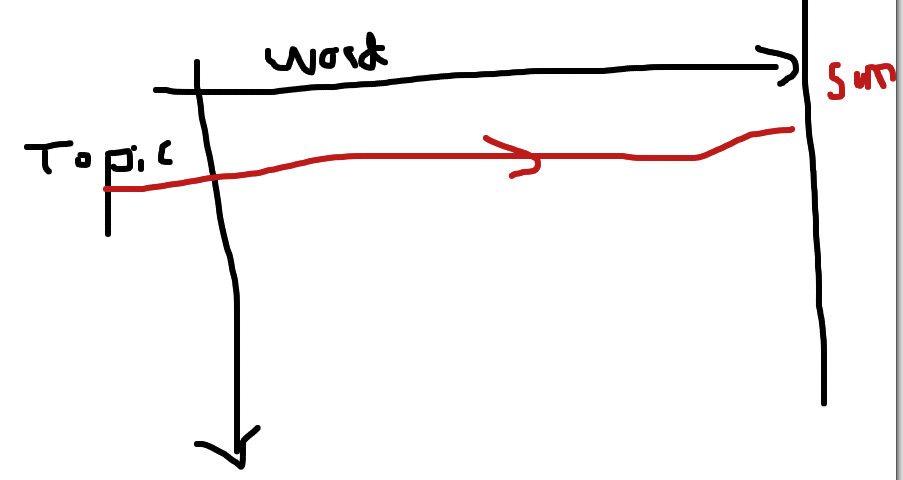

In [3]:
NUM_TOPIC = 22
tf_feature_names = tf_info.pid.values
with open(constants.LDA_DIR + 'lda_%d.model'%NUM_TOPIC, 'rb') as f:# replace 10
    lda = pickle.load(f)

# 每个话题是一个商品上的分布, 除以topic的总比重得到每个单词对每个Topic的贡献比重
# np.newaxis turn (22,) into (22,1)
norm_comp = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# 每个商品也可对应一个话题的分布，对每个单词的分布归一化使得概率和为1
norm_comp = norm_comp / norm_comp.sum(axis=0)

topic_product = pd.DataFrame(norm_comp.transpose(), columns = ["topic_%d"%x for x in range(NUM_TOPIC)])
topic_product['product_id'] = [int(x) for x in tf_feature_names]

user_topic = lda.transform(user_tf_matrix)
user_topic = pd.DataFrame(user_topic, columns = ["topic_%d"%x for x in range(NUM_TOPIC)])
user_id = users_products_matrix.index.values
user_topic['user_id'] = user_id

with open(DATA_DIR + 'user_topic_%d.pkl'%NUM_TOPIC, 'wb') as f:
    pickle.dump(user_topic, f, pickle.HIGHEST_PROTOCOL)
with open(DATA_DIR + 'topic_product_%d.pkl'%NUM_TOPIC, 'wb') as f:
    pickle.dump(topic_product, f, pickle.HIGHEST_PROTOCOL)

In [23]:
with open(DATA_DIR + 'user_topic_%d.pkl'%NUM_TOPIC, 'rb') as f:
    user_topic = pickle.load(f)
with open(DATA_DIR + 'topic_product_%d.pkl'%NUM_TOPIC, 'rb') as f:
    topic_product = pickle.load(f)

In [24]:
user_topic.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,user_id
0,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,...,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.824115,0.160733,1
1,0.219863,0.328432,0.000232,0.000232,0.000232,0.000232,0.000232,0.081220,0.000232,0.000232,...,0.000232,0.000232,0.141024,0.000232,0.014159,0.007315,0.000232,0.000232,0.064054,2
2,0.000511,0.000511,0.000511,0.000511,0.000511,0.000511,0.000511,0.040710,0.000511,0.000511,...,0.000511,0.000511,0.000511,0.000511,0.000511,0.000511,0.267233,0.000511,0.000511,3
3,0.002392,0.155019,0.002392,0.147681,0.002392,0.002392,0.147115,0.002392,0.002392,0.002392,...,0.002392,0.002392,0.429475,0.002392,0.002392,0.002392,0.002392,0.002392,0.002392,4
4,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.082725,0.001196,0.267468,0.001196,...,0.001196,0.001196,0.001196,0.327071,0.001196,0.001196,0.135903,0.001196,0.001196,5


In [34]:
topic_product.describe()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,product_id
count,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,...,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,4.950200e+04,49502.000000
mean,2.071187e-02,4.297420e-02,2.061694e-02,1.449651e-01,1.316624e-01,7.544303e-02,9.560222e-02,2.142675e-02,3.119877e-02,3.616593e-02,...,7.031256e-02,3.686334e-02,2.114678e-02,2.551775e-02,2.244161e-02,3.612258e-02,1.699803e-02,1.720467e-02,6.205733e-02,24842.740596
std,1.153336e-01,1.744168e-01,1.173358e-01,3.151527e-01,3.069833e-01,2.397469e-01,2.703631e-01,1.171711e-01,1.398321e-01,1.611797e-01,...,2.324126e-01,1.578139e-01,1.173304e-01,1.293245e-01,1.240478e-01,1.630636e-01,9.890282e-02,1.152595e-01,2.160707e-01,14341.538265
min,4.020548e-07,1.171701e-07,7.004441e-07,8.391984e-08,9.617313e-08,2.132926e-07,2.232470e-07,6.703903e-08,4.445199e-08,1.643594e-07,...,2.033900e-07,1.779033e-07,2.336483e-07,1.128044e-07,2.281761e-07,2.827442e-07,6.110517e-08,1.377766e-07,1.515296e-07,10.000000
25%,5.334306e-04,2.334441e-04,4.473016e-04,1.568620e-04,1.687339e-04,3.241162e-04,3.434469e-04,1.214424e-04,8.576851e-05,2.849395e-04,...,3.785302e-04,3.369231e-04,3.002882e-04,1.727633e-04,3.630267e-04,4.672501e-04,8.570874e-05,2.161908e-04,2.882629e-04,12423.250000
50%,2.272983e-03,9.816725e-04,1.865658e-03,7.791897e-04,8.470000e-04,1.462547e-03,1.627055e-03,5.090929e-04,3.661115e-04,1.223354e-03,...,1.703352e-03,1.416136e-03,1.249110e-03,7.168506e-04,1.551240e-03,2.032063e-03,3.521996e-04,9.192500e-04,1.265839e-03,24837.500000
75%,7.463243e-03,3.329147e-03,6.104337e-03,4.013391e-03,3.925575e-03,5.509219e-03,6.387709e-03,1.698692e-03,1.256391e-03,4.147900e-03,...,6.174209e-03,4.757978e-03,4.094956e-03,2.399405e-03,5.176193e-03,6.872019e-03,1.168727e-03,3.014119e-03,4.461865e-03,37264.750000
max,9.999848e-01,9.998180e-01,9.999611e-01,9.996492e-01,9.998125e-01,9.999144e-01,9.999441e-01,9.999317e-01,9.997679e-01,9.999452e-01,...,9.999052e-01,9.999820e-01,9.999077e-01,9.998526e-01,9.999910e-01,9.999606e-01,9.995263e-01,9.999194e-01,9.999496e-01,49688.000000


### 基于方案2的Nearest Neighbors Search
- 每个人一个NN，找到与user topic最近的商品
- 分析pred中None的数量
- avg_reorder_len, component无normalize, 欧氏聚类时的得分：f1score:0.078288109250376284
- avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.11
- 2 * avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.15
- 3 * avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.178
- 4 * avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.19
- 5 * avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.20
- avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.11:0.107
- norm, 2 * avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.146
- norm, 3 * avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.168
- norm, 4 * avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.18
- norm, 5 * avg_reorder_len, component normalize，l1距离时的扥分：f1score:0.19
- avg_reorder_len, component normalize，欧氏距离时的扥分：f1score:0.11

- avg_reorder_len, component normalize, 对称KL距离时的得分: f1score:0.108


In [26]:
with open(DATA_DIR + 'user_product.pkl', 'rb') as f:
    user_product = pickle.load(f)

In [27]:
with open(DATA_DIR + 'user_reorder_est.pkl', 'rb') as f:
    avg_reorder_est = pickle.load(f)

In [28]:
train_orders = orders[orders.eval_set == 'train']

In [29]:
#%%time
u_nnp = []
cnt = 0
for u in train_orders.user_id:
    cnt += 1
    if cnt % 10000 == 0:
        print("Nearest Product Search for %dth user"%cnt)
    # extract user u's topic
    u_topic = user_topic[user_topic.user_id == u][["topic_%d"%x for x in range(10)]]
    # extract user u's product list
    u_products = user_product[user_product.user_id == u]['product_id']
    # extract avg_reorder_num
    u_reorder = avg_reorder_est[avg_reorder_est.user_id == u]['avg_reorder_num']
    # extract products' topic
    p_topics = topic_product[topic_product.product_id.isin(set(u_products.values[0]))]
    p_topics_pid = p_topics['product_id'].reset_index()['product_id']
    p_topics_vec = p_topics[["topic_%d"%x for x in range(10)]]
    # nbr search, expand search scope
    n_neighbors = 1 * int(np.ceil(u_reorder.values[0]))
    if n_neighbors > len(p_topics_vec):
        n_neighbors = len(p_topics_vec)
    if n_neighbors > 0:
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, 
                                metric = 'l1',
                                algorithm = 'brute').fit(p_topics_vec.values)
        #print(u)
        distances, indices = nbrs.kneighbors(u_topic.values.reshape(1, -1))
        #print(cnt)
        u_nnp.append(list(p_topics_pid[indices[0]].values))
    else:
        u_nnp.append('None')
    

Nearest Product Search for 10000th user
Nearest Product Search for 20000th user
Nearest Product Search for 30000th user
Nearest Product Search for 40000th user
Nearest Product Search for 50000th user
Nearest Product Search for 60000th user
Nearest Product Search for 70000th user
Nearest Product Search for 80000th user
Nearest Product Search for 90000th user
Nearest Product Search for 100000th user
Nearest Product Search for 110000th user
Nearest Product Search for 120000th user
Nearest Product Search for 130000th user


### 方案2 结果评估

In [30]:
train_pred = pd.DataFrame({'user_id':train_orders.user_id, 
                                 'reorder_pids':u_nnp, 
                                 'order_id':train_orders.order_id})

train_gold = order_products_train[order_products_train.reordered == 1].groupby(['order_id'])['product_id'].apply(list)

train_gold = train_gold.reset_index()

train_eval = pd.merge(train_gold, train_pred, on = ['order_id'], how = 'outer').fillna('None')

train_eval.columns = ['order_id', 'gold_reorder', 'pred_reorder', 'user_id']
    

In [31]:
# 21mins
train_eval['f1score'] = train_eval.apply(wrap_cal_f1, axis = 1)

train_eval['precision'] = train_eval.apply(wrap_cal_precision, axis = 1)

train_eval['recall'] = train_eval.apply(wrap_cal_recall, axis = 1)

In [32]:
train_eval.f1score.mean()

0.11241217855250955

In [33]:
train_eval.describe()

,order_id,user_id,f1score,precision,recall
count,1.312090e+05,131209.000000,131209.000000,131209.000000,131209.000000
mean,1.704050e+06,103166.825317,0.112412,0.139801,0.106983
std,9.889077e+05,59565.307804,0.186428,0.228738,0.193099
min,1.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,8.451640e+05,51587.000000,0.000000,0.000000,0.000000
50%,1.696847e+06,103150.000000,0.000000,0.000000,0.000000
75%,2.561480e+06,154868.000000,0.181818,0.222222,0.166667
max,3.421070e+06,206209.000000,1.000000,1.000000,1.000000


In [389]:
train_eval[train_eval.user_id == 201]

,order_id,gold_reorder,pred_reorder,user_id,f1score,precision,recall
99725,2780124,[329],"[27845, 21137, 20597]",201,0.0,0.0,0.0


In [378]:
prior_all = pd.merge(order_products_prior, orders, on = ['order_id'], how = 'left')

In [379]:
prior_all = pd.merge(prior_all,
                     product_ad[['product_id', 'product_name', 'aisle', 'department']],
                     on = ['product_id'],
                     how = 'left')

### 方案1 每张订单的Embeded Topic Space表达

In [132]:
%%time
order_topic = lda_10.transform(order_tf_matrix)

CPU times: user 2min 19s, sys: 1.02 s, total: 2min 20s
Wall time: 2min 20s


In [130]:
with open(DATA_DIR + 'tf_matrix', 'rb') as f:
    order_tf_matrix = pickle.load(f)

In [144]:
order_products_matrix = order_products_matrix.reset_index()

In [152]:
order_topic = pd.DataFrame(order_topic, columns = ["topic_%d"%x for x in range(10)])

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
count,3.346083e+06,3.346083e+06,3.346083e+06,3.346083e+06,3.346083e+06,3.346083e+06,3.346083e+06,3.346083e+06,3.346083e+06,3.346083e+06
mean,7.187041e-02,7.391911e-02,9.607594e-02,1.156562e-01,1.179394e-01,7.870632e-02,1.141647e-01,8.240011e-02,7.278592e-02,1.764819e-01
std,8.987800e-02,9.078519e-02,1.461682e-01,1.689784e-01,1.365042e-01,9.874789e-02,1.307131e-01,1.187880e-01,9.578959e-02,1.862984e-01
min,1.163040e-03,1.204819e-03,9.524070e-04,9.901641e-04,1.234594e-03,1.204894e-03,1.075358e-03,1.111149e-03,1.086957e-03,9.901753e-04
25%,1.250000e-02,1.250000e-02,1.111111e-02,1.000000e-02,1.428571e-02,1.250000e-02,1.428571e-02,1.000038e-02,1.111147e-02,1.666736e-02
50%,3.333333e-02,3.333333e-02,2.500000e-02,2.500000e-02,5.000000e-02,3.333333e-02,5.000000e-02,2.500000e-02,2.500000e-02,1.056638e-01
75%,1.079073e-01,1.100000e-01,1.221843e-01,1.615385e-01,1.851988e-01,1.166667e-01,1.833333e-01,1.100000e-01,1.040230e-01,3.008785e-01
max,9.250000e-01,9.099995e-01,9.357143e-01,9.571429e-01,9.307675e-01,9.000000e-01,9.399988e-01,9.181818e-01,9.357143e-01,9.678567e-01
